In [54]:
from uuid import UUID
import sys
import logging 
import arrow
import pandas as pd
import public_data

import matplotlib.pyplot as plt
%matplotlib inline
import datetime as pydt
import emission.core.get_database as edb
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt

logging.getLogger().setLevel(logging.DEBUG)
logger = logging.getLogger()
#logger.handlers[0].stream = sys.stdout

In [55]:
iphone_ids_all = ["079e0f1a-c440-3d7c-b0e7-de160f748e35", "c76a0487-7e5a-3b17-a449-47be666b36f6", 
              "c528bcd2-a88b-3e82-be62-ef4f2396967a", "95e70727-a04e-3e33-b7fe-34ab19194f8b"]
android_ids_all = ["e471711e-bd14-3dbe-80b6-9c7d92ecc296", "fd7b4c2e-2c8b-3bfa-94f0-d1e3ecbd5fb7",
             "86842c35-da28-32ed-a90e-2da6663c5c73", "3bc0f91f-7660-34a2-b005-5c399598a369"]

In [56]:
exp_df = pd.read_csv("experiments.csv")
exp_df

,index,experiment,start_time,end_time,start_ts,end_ts,label,notes,description
0,0,standby,2016-07-02T16:00:00-07:00,2016-07-08T00:00:00-07:00,1467500400,1467961200,"1hr,1hr,1hr,1hr","iphone4 reported no data, android3 drained faster",phone sitting stationary
1,1,HAFS *iphone* + HAMS 30s *android*,2016-07-11T18:00:34.967853-07:00,2016-07-14T15:40:19.652000-07:00,1468285235,1468536020,"1hr,1hr,1hr,1hr",iphone 4 drained faster,"high accuracy, fast sampling location tracking"
2,2,HAFS location (stationary),2016-07-17T11:12:33.859000-07:00,2016-07-18T11:00:27.966900-07:00,1468782026,1468864828,"1hr,1hr,1hr,1hr",consistent ios & android,NaN
3,3,HAFS location (stationary),2016-07-20T08:00:07.669725-07:00,2016-07-21T07:00:34.099522-07:00,1469026808,1469109634,"1hr,1hr,1hr,1hr",consistent ios & android,NaN
4,4,HAFS location (stationary) *android only*,2016-07-21T11:11:55.444000-07:00,2016-07-22T07:18:25.989000-07:00,1469124715,1469197106,"1hr,1hr,1hr,1hr","android2 drained faster, android 3 start at 95%",NaN
5,5,HAFS location (stationary),2016-07-27T17:46:23.459000-07:00,2016-07-28T17:00:23.909602-07:00,1469666783,1469750424,"1hr,1hr,1hr,1hr","consistent ios, android bimodal",NaN
6,6,MAFS lacation (moving),2016-07-29T11:00:04.500982-07:00,2016-07-29T21:00:23.752410-07:00,1469815205,1469851224,"1hr,1hr,1hr,1hr","iphone4 reported no data, android bimodal",travelled from berkeley to mountain view
7,7,video playback,2016-07-29T22:39:43.046000-07:00,2016-07-30T05:00:19.731261-07:00,1469857183,1469880020,"1hr,1hr,1hr,1hr",iphone4 reported no data,"same freq, max brightness, airplane mode, loca..."
8,8,video playback (diff freq),2016-07-30T13:03:01.030000-07:00,2016-07-30T18:40:30.291000-07:00,1469908981,1469932204,"1min,10min,30min,1hr",iphone4 reported no data,"diff freq (1min, 10min, 30min), max brightness..."
9,9,MAFS lacation (moving) *iphone only*,2016-08-01T08:00:14.770948-07:00,2016-08-01T09:45:01.017547-07:00,1470063615,1470069901,"1hr,1hr,1hr,1hr",no meaningful andorid data (too few data points),travelled from mountain view to berkeley


In [57]:
# Pulling data from the server ...
# Select the index for the experiment you want to load data for
# Set index to -1 if you want to load data for all experiments
load_exp_index = 6

# Select the index for the experiment you want to analyze
exp_index = 6

In [58]:
server_url = 'https://e-mission.eecs.berkeley.edu'

start_ts = exp_df.start_ts.iloc[load_exp_index]
end_ts = exp_df.end_ts.iloc[load_exp_index]

phone_ids = iphone_ids_all + android_ids_all

In [59]:
def loadAll():
    print 'Pulling data for all experiments: ' 
    start_times = list(exp_df.start_ts)
    end_times = list(exp_df.end_ts)
    for i in range(len(start_times)):
        print 'Loading data from ' + str(start_times[i]) + ' to ' + str(end_times[i])
        public_data.request_batched_data(server_url, start_times[index], end_times[index], phone_ids)

In [60]:
if load_exp_index == -1: 
    loadAll()
else:
    print 'Pulling data for experiment: ' + exp_df.experiment.iloc[load_exp_index] 
    print 'from ' + exp_df.start_time.iloc[load_exp_index] + ' to ' + exp_df.end_time.iloc[load_exp_index]
    public_data.request_batched_data(server_url, start_ts, end_ts, phone_ids)

INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): e-mission.eecs.berkeley.edu


Pulling data for experiment: MAFS lacation (moving) 
from 2016-07-29T11:00:04.500982-07:00 to 2016-07-29T21:00:23.752410-07:00


DEBUG:requests.packages.urllib3.connectionpool:"GET /eval/publicData/timeseries?from_ts=1469815205&to_ts=1469833205 HTTP/1.1" 200 9114970
DEBUG:root:phone1 first entry (in Pacific Time):
DEBUG:root:2016-07-29T11:00:13.897848-07:00
DEBUG:root:phone2 first entry (in Pacific Time):
DEBUG:root:2016-07-29T11:00:44.498729-07:00
DEBUG:root:phone3 first entry (in Pacific Time):
DEBUG:root:2016-07-29T11:00:05.031302-07:00
DEBUG:root:phone4 first entry (in Pacific Time):
DEBUG:root:...has no data...
DEBUG:root:phone5 first entry (in Pacific Time):
DEBUG:root:2016-07-29T11:05:02.768000-07:00
DEBUG:root:phone6 first entry (in Pacific Time):
DEBUG:root:2016-07-29T11:03:28-07:00
DEBUG:root:phone7 first entry (in Pacific Time):
DEBUG:root:2016-07-29T11:00:55.313000-07:00
DEBUG:root:phone8 first entry (in Pacific Time):
DEBUG:root:2016-07-29T11:00:10.193000-07:00
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): e-mission.eecs.berkeley.edu
DEBUG:requests.packages.urllib3

Data loaded to local server!


In [61]:
# Analyzing the data ... 

android_ids = android_ids_all
if  'iphone4 reported no data' in exp_df.notes.iloc[exp_index]:
    iphone_ids = iphone_ids_all[0:3]
    print 'not data for iphone4'
else:
    iphone_ids = iphone_ids_all

plot_iphone = True
plot_android = True
if 'android only' in exp_df.experiment.iloc[exp_index]:
    plot_iphone = False
if 'iphone only' in exp_df.experiment.iloc[exp_index]:
    plot_android = False

not data for iphone4


In [62]:
logger.setLevel(logging.CRITICAL)

iphone_ts = map(lambda u: esta.TimeSeries.get_time_series(UUID(u)), iphone_ids)
android_ts = map(lambda u: esta.TimeSeries.get_time_series(UUID(u)), android_ids)

#time query specification
time_range = estt.TimeQuery("metadata.write_ts", start_ts, end_ts)

iphone_state_df_list = map(lambda t:t.get_data_df("statemachine/transition", time_range), iphone_ts)
android_state_df_list = map(lambda t:t.get_data_df("statemachine/transition", time_range), android_ts)

iphone_battery_df_list = map(lambda t:t.get_data_df("background/battery", time_range), iphone_ts)
android_battery_df_list = map(lambda t:t.get_data_df("background/battery", time_range), android_ts)
iphone_battery_df_list = map(lambda d:d[d.battery_status!=2], iphone_battery_df_list)
android_battery_df_list = map(lambda d:d[d.battery_status!=2], android_battery_df_list)

In [63]:
android_test = android_battery_df_list[0]
android_test[['fmt_time', 'battery_level_pct', 'battery_status']][0:2]

,fmt_time,battery_level_pct,battery_status
0,2016-07-29T12:47:37.405000-07:00,98,1
1,2016-07-29T14:17:16.090000-07:00,98,1


In [64]:
iphone_test = iphone_battery_df_list[0]
iphone_test[['fmt_time', 'battery_level_pct', 'battery_status']][0:2]

,fmt_time,battery_level_pct,battery_status
0,2016-07-29T11:00:13.917096-07:00,100.0,1
1,2016-07-29T12:00:13.165131-07:00,100.0,1


In [65]:
import numpy as np

iphone_xnew = np.arange(start_ts, end_ts, 15 * 60) # 15 minutes
android_xnew = np.arange(start_ts, end_ts, 15 * 60) # 15 minutes

In [66]:
import scipy.interpolate as spi
import numpy as np

def get_interpolated(x, y, xnew):
    # fn = spi.interp1d(x=x, y=y, bounds_error=False, fill_value=y.iloc[-1])
    fn = spi.interp1d(x=x, y=y, bounds_error=False)
    return fn(xnew)

In [67]:
def get_interpolated_df(sensor_df, xnew):
    local_dt_new = map(pydt.datetime.fromtimestamp, xnew)
    fmt_time_new = map(lambda dt: dt.isoformat(), local_dt_new)
    interpolated_series = get_interpolated(sensor_df.ts, sensor_df.battery_level_pct, xnew)
    interpolated_df = pd.DataFrame(data={'ts': xnew, 'metadata_write_ts': xnew, 'local_dt': local_dt_new, 'fmt_time': fmt_time_new, 'battery_level_pct': interpolated_series})
    return interpolated_df

In [68]:
if plot_iphone:
    iphone_battery_interp_df_list = map(lambda df: get_interpolated_df(df, iphone_xnew), iphone_battery_df_list)

In [69]:
if plot_android:
    android_battery_interp_df_list = map(lambda df: get_interpolated_df(df, android_xnew), android_battery_df_list)

In [70]:
title = exp_df.experiment.iloc[exp_index] 
text = exp_df.label.iloc[exp_index] 
label = text.split(",") 
style = ['ob', 'og', 'or', 'oc']

ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)

About to plot 0
About to plot 1
About to plot 2
About to plot 0
About to plot 1
About to plot 2


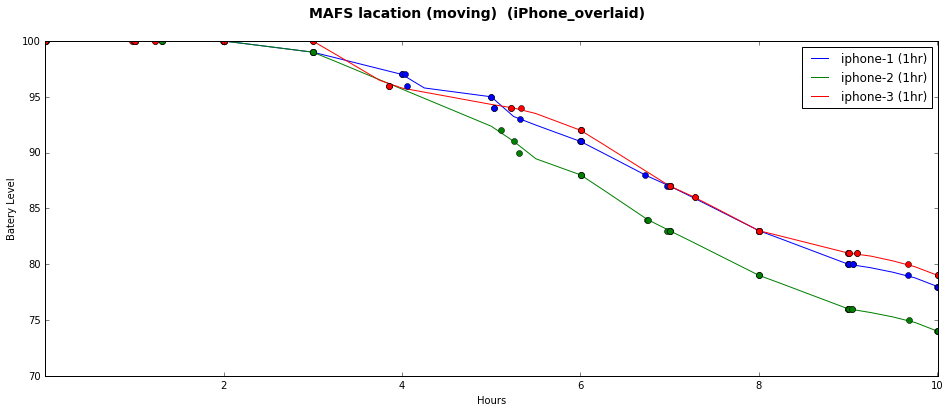

In [71]:
#iPhone: With interplation on battery data 
if plot_iphone:
    (ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
    iaxes = iaxes2d

    ifig.suptitle(title + ' (iPhone_overlaid)', fontsize=14, fontweight='bold')

    for i, df in enumerate(iphone_battery_interp_df_list):
        print "About to plot %d" % i
        df['hr'] = (df.ts-start_ts)/3600.0
        df.plot(x='hr', y='battery_level_pct', ax=iaxes, label=("iphone-%s " % (i+1))+'('+label[i]+')', xlim=(min(df.hr), max(df.hr)), legend=True)


    for i, df in enumerate(iphone_battery_df_list):
        print "About to plot %d" % i
        df['hr'] = (df.ts-start_ts)/3600.0
        df.plot(x='hr', y='battery_level_pct', style=style[i], ax=iaxes,  xlim=(min(df.hr), max(df.hr)), legend=False)
        iaxes.set_xlabel('Hours')
        iaxes.set_ylabel('Batery Level')
        #plt.xticks(np.arange(min(df.dt), max(df.dt), 1))

In [72]:
from scipy import stats

if plot_iphone:
    total=[]
    print "From linear model fitting ..." 
    for i, df in enumerate(iphone_battery_interp_df_list):
        notnull = df.battery_level_pct.notnull()
        slope, intercept, r_value, p_value, std_err = stats.linregress(df.hr[notnull], df.battery_level_pct[notnull])
        print "ios %d: " % (i+1)  + "slope="+str(slope) + " %/hr  std_err="+str(std_err)
        total.append(slope)

    print "average slope=" + str(sum(total)/4) + " %/hr  std dev=" + str(np.std(total))

From linear model fitting ...
ios 1: slope=-2.58385507373 %/hr  std_err=0.10186626465
ios 2: slope=-3.15141545913 %/hr  std_err=0.110817317085
ios 3: slope=-2.49433707 %/hr  std_err=0.0996448082672
average slope=-2.05740190072 %/hr  std dev=0.29095442055


In [73]:
#iphone data
if plot_iphone:
    for i, phone in enumerate(iphone_battery_df_list):
        batt = phone
        x = batt.metadata_write_ts
        y = batt.battery_level_pct

        p1 = np.polyfit(x,y,1)
        p2 = np.polyfit(x,y,2) 

        yfit1 = np.polyval(p1,x)
        yfit2 = np.polyval(p2,x)

        print 'ios ' + str(i+1)
        print 'linear_fit: RMSE = ' + str(np.mean((y - yfit1) ** 2)**0.5)
        print 'quadratic_fit: RMSE = ' + str(np.mean((y - yfit2) ** 2)**0.5)
        print 

ios 1
linear_fit: RMSE = 1.79051851268
quadratic_fit: RMSE = 0.921256075674

ios 2
linear_fit: RMSE = 1.80417062508
quadratic_fit: RMSE = 1.35367461458

ios 3
linear_fit: RMSE = 1.85367261278
quadratic_fit: RMSE = 1.14206466898



About to plot 0
About to plot 1
About to plot 2
About to plot 3
About to plot 0
About to plot 1
About to plot 2
About to plot 3


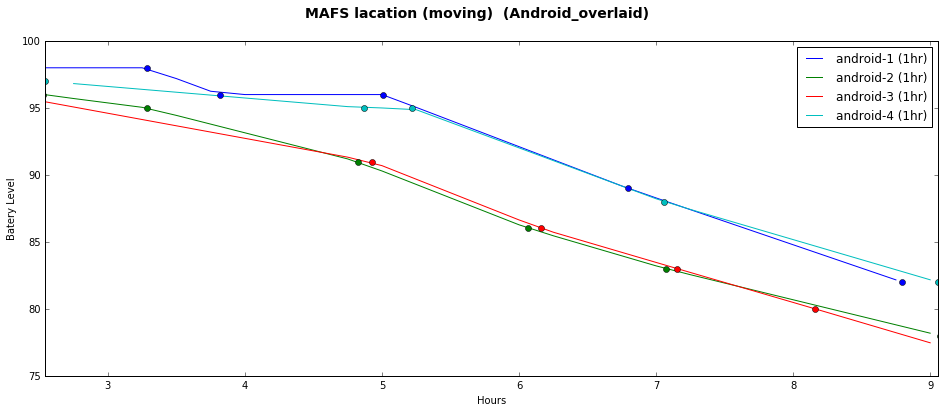

In [74]:
#Android: With interplation on battery data 
if plot_android:
    (ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
    iaxes = iaxes2d

    ifig.suptitle(title + ' (Android_overlaid)', fontsize=14, fontweight='bold')

    for i, df in enumerate(android_battery_interp_df_list):
        print "About to plot %d" % i
        df['hr'] = (df.ts-start_ts)/3600.0
        df.plot(x='hr', y='battery_level_pct', ax=iaxes, label=("android-%s " % (i+1))+'('+label[i]+')', xlim=(min(df.hr), max(df.hr)), legend=True)
        
        
    for i, df in enumerate(android_battery_df_list):
        print "About to plot %d" % i
        df['hr'] = (df.ts-start_ts)/3600.0
        df.plot(x='hr', y='battery_level_pct', style=style[i], ax=iaxes,  xlim=(min(df.hr), max(df.hr)), legend=False)
        iaxes.set_xlabel('Hours')
        iaxes.set_ylabel('Batery Level')
        #plt.xticks(np.arange(min(df.dt), max(df.dt), 1))

In [75]:
from scipy import stats

if plot_android:
    total=[]
    print "From linear model fitting ..." 
    for i, df in enumerate(android_battery_interp_df_list):
        notnull = df.battery_level_pct.notnull()
        slope, intercept, r_value, p_value, std_err = stats.linregress(df.hr[notnull], df.battery_level_pct[notnull])
        print "android %d: " % (i+1)  + "slope="+str(slope) + " %/hr  std_err="+str(std_err)
        total.append(slope)

    print "average slope=" + str(sum(total)/4) + " %/hr  std dev=" + str(np.std(total))

From linear model fitting ...
android 1: slope=-2.4891873639 %/hr  std_err=0.135886913243
android 2: slope=-2.65331815949 %/hr  std_err=0.0576013890697
android 3: slope=-2.58943106254 %/hr  std_err=0.0601022981972
android 4: slope=-2.51666370104 %/hr  std_err=0.122197934557
average slope=-2.56215007174 %/hr  std dev=0.0641257345719


In [76]:
#android data
if plot_android:
    for i, phone in enumerate(android_battery_df_list):
        batt = phone
        x = batt.metadata_write_ts
        y = batt.battery_level_pct

        p1 = np.polyfit(x,y,1)
        p2 = np.polyfit(x,y,2) 

        yfit1 = np.polyval(p1,x)
        yfit2 = np.polyval(p2,x)

        print 'android ' + str(i+1)
        print 'linear_fit: RMSE = ' + str(np.mean((y - yfit1) ** 2)**0.5)
        print 'quadratic_fit: RMSE = ' + str(np.mean((y - yfit2) ** 2)**0.5)
        print 

android 1
linear_fit: RMSE = 1.86324005163
quadratic_fit: RMSE = 0.741754473997

android 2
linear_fit: RMSE = 1.05991348259
quadratic_fit: RMSE = 0.674277660613

android 3
linear_fit: RMSE = 1.02241690412
quadratic_fit: RMSE = 0.500077760758

android 4
linear_fit: RMSE = 1.68175015705
quadratic_fit: RMSE = 0.737056220256

